# Home Credit Default Risk
## Data
The data is provided by Home Credit, a service dedicated to provided lines of credit (loans) to the unbanked population. Predicting whether or not a client will repay a loan or have difficulty is a critical business need, and Home Credit is hosting this competition on Kaggle to see what sort of models the machine learning community can develop to help them in this task.


## Import Libraries

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, RobustScaler
import warnings
import math
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [ ]:
warnings.simplefilter(action='ignore', category=Warning)

# Read Dataset

In [ ]:
path = '/kaggle/input/application-datasets/application_train.csv'
df_train = pd.read_csv(path)

In [ ]:
df_train.head()

## Exploratory Data Analysis
Exploratory Data Analysis (EDA) is an open-ended process where we calculate statistics and make figures to find trends, anomalies, patterns, or relationships within the data. The goal of EDA is to learn what our data can tell us. It generally starts out with a high level overview, then narrows in to specific areas as we find intriguing areas of the data. The findings may be interesting in their own right, or they can be used to inform our modeling choices, such as by helping us decide which features to use.

In [ ]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)


In [ ]:
check_df(df_train)

# Split DataSet

Split the dataset into three types: categorical, numerical, and cardinal. This separation will assist us in analyzing each type individually. Please provide the names of the categorical variables, numerical variables, and those that are categorical but have a numeric appearance in the dataset. > 

*Note that categorical variables that appear numeric should also be included in the categorical group.*

In [ ]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """
       veri setindeki kategorik, numeric ve kategorik fakat kardinal değişkenlerin isimlerini verir.
       Not: kategorik değikenlerin içersine numerik görünümlü ketagorik değişkenler de dahildir.

       Args:
           dataframe: dataframe
               değişken isimleri alınmak istenen dataframe'dir,
           cat_th: int, float
               numerik fakat kategorik olan değişkenler için sınıf eşik değeri.
           car_th: int, float
               kategorik fakat kardinal değişkenler için sınıf eşik değeri.

       Returns:
           cat_cols: list
               kategorik değişken listesi
           num_cols: list
               numerik değişken listesi
           cat_but_car: list
               kategorik görünümlü kardinal değişken listesi

       Notes:
           cat_cols + num_cols + cat_but_car = toplam değişken sayısı
           num_but_cat cat_cols'un içerisinde.

       """

    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                                                       dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                                                       dataframe[col].dtypes == "O"]

    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    #Number Columns
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]
    num_cols = [col for col in num_cols if dataframe[col].nunique() != len(dataframe)]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car


In [ ]:
cat_cols, num_cols, cat_but_car = grab_col_names(df_train)

### Exmine Numeric Features

In [ ]:
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(f"**********  {numerical_col} **********")
    print(dataframe[numerical_col].describe(quantiles).T)
    print("**********************************************")

    if plot:
        dataframe[numerical_col].hist()
        plt.title(numerical_col)
        plt.xlabel(numerical_col)
        plt.show(block=True)


In [ ]:
for col in num_cols:
    num_summary(df_train, col)

## Outlier

### Exmine Outlier

In [ ]:
def outlier_threshold(dataframe, col_name, q1=0.25, q3=0.75):
    quantile1 = dataframe[col_name].quantile(q1)
    quantile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quantile3 - quantile1
    up_limit = quantile3 + 1.5 * interquantile_range
    low_limit = quantile1 - 1.5 * interquantile_range
    return up_limit, low_limit


In [ ]:
def check_outliers(dataframe, col_name, q1= 0.25, q3=0.75):
    up_limit, low_limit = outlier_threshold(dataframe, col_name, q1, q3)
    return dataframe[(dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit)].any(axis=None)


In [ ]:
box_list = []
for col in num_cols:
    print(col, " ", check_outliers(df_train, col))
    if check_outliers(df_train, col):
        box_list.append(col)

In [ ]:
plt.figure(figsize=(10, 8))
df_train.boxplot(column=box_list[10:20])
plt.xticks(rotation=45, ha='right')

In [ ]:
def grab_outliers(dataframe, col_name, index=False):
    up_limit, low_limit = outlier_threshold(dataframe, col_name)

    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].shape[0] > 10:
        print(dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].head())
    else:
        print(dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)])

    if index:
        outliers_index = dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].index
        return outliers_index


In [ ]:
for col in num_cols:
    outliers_index =  grab_outliers(df_train, col, index=True)

In [ ]:
df_train.iloc[outliers_index].head()

In [ ]:
def replace_with_thresholds(dataframe, variable):
    up_limit, low_limit = outlier_threshold(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit


In [ ]:
for col in num_cols:
    replace_with_thresholds(df_train, col)

In [ ]:
for col in num_cols:
    print(col, " ", check_outliers(df_train, col))

## Missing Values

### Examine Missing Values

#### Advanced Missin Value Anlysis

In [ ]:
import missingno as msno

In [ ]:
msno.bar(df_train)
plt.show()

In [ ]:
msno.matrix(df_train)

In [ ]:
df_train['TARGET'].value_counts() / len(df_train) * 100

In [ ]:
def missing_values_table(dataframe, na_name=False):
    na_cols = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_cols].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_cols].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    n_miss_cols = ratio[ratio > 10.0].index
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end='\n')
    if na_name:
        return na_cols, n_miss_cols

In [ ]:
na_cols, n_miss_cols = missing_values_table(df_train, True)

In [ ]:
n_miss_cols

#### Drop Missing Value Bigger than Average

In [ ]:
df_train.drop(n_miss_cols, axis=1, inplace=True)

In [ ]:
na_cols, n_miss_cols = missing_values_table(df_train, True)

### Imputer Another Missing Value

In [ ]:
from sklearn.impute import KNNImputer

In [ ]:
imputer = KNNImputer(n_neighbors=5)

In [ ]:
cat_cols, num_cols, cat_but_car = grab_col_names(df_train)

In [ ]:
na_num_cols = df_train[na_cols].select_dtypes(include='float').columns

In [ ]:
df_train[na_num_cols] = pd.DataFrame(imputer.fit_transform(df_train[na_num_cols]), columns=df_train[na_num_cols].columns)

In [ ]:
na_cols, n_miss_cols = missing_values_table(df_train, True)

### Imputer Categorical Columns

In [ ]:
name_type_col_mode = df_train[na_cols].value_counts().index[0][0]
name_type_col_mode

In [ ]:
df_train.loc[df_train[na_cols].isnull().NAME_TYPE_SUITE.values, na_cols] = name_type_col_mode

In [ ]:
df_train[na_cols].isnull().sum()

In [ ]:
df_train['TARGET'].values

# Scaling Data

In [ ]:
df_train[num_cols].dtypes

In [ ]:
robust_scaler = RobustScaler()

In [ ]:
df_train[num_cols] = robust_scaler.fit_transform(df_train[num_cols])

In [ ]:
df_train[num_cols].head()

## Encoding

### Label Encoding
Label encoding: assign each unique category in a categorical variable with an integer. No new columns are created.

In [ ]:
def label_encoder(dataframe, binary_col):
    labelEncoder = LabelEncoder()
    dataframe[binary_col] = labelEncoder.fit_transform(dataframe[binary_col])
    return dataframe

In [ ]:
binary_cols = [col for col in df_train.columns if df_train[col].dtypes not in ['int64', 'float64'] and df_train[col].nunique() == 2]

In [ ]:
for col in binary_cols:
    label_encoder(df_train, col)

In [ ]:
df_train[cat_cols].head()

In [ ]:
for col in cat_cols:
    print(df_train[col].value_counts())
    print("----------------------------")

### One Hot Encoder
One-hot encoding: create a new column for each unique category in a categorical variable. Each observation recieves a 1 in the column for its corresponding category and a 0 in all other new columns.

In [ ]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [ ]:
one_hot_cols = [col for col in cat_cols if 10 >= df_train[col].nunique() > 2]

In [ ]:
one_hot_cols

In [ ]:
df_train = one_hot_encoder(df_train, one_hot_cols, True)

In [ ]:
df_train.head()

In [ ]:
df_train.shape

The problem with label encoding is that it gives the categories an arbitrary ordering. The value assigned to each of the categories is random and does not reflect any inherent aspect of the category. In the example above, programmer recieves a 4 and data scientist a 1, but if we did the same process again, the labels could be reversed or completely different. The actual assignment of the integers is arbitrary. Therefore, when we perform label encoding, the model might use the relative value of the feature (for example programmer = 4 and data scientist = 1) to assign weights which is not what we want. If we only have two unique values for a categorical variable (such as Male/Female), then label encoding is fine, but for more than 2 unique categories, one-hot encoding is the safe option.

## Data Analysis

In [ ]:
df_train["TARGET"].value_counts()

In [ ]:
cat_cols, num_cols, cat_but_car = grab_col_names(df_train)

In [ ]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("****************************************************")

    if plot:
        sns.countplot(x=col_name, data=dataframe)
        plt.show(block=True)


In [ ]:
for col in cat_cols:
    cat_summary(df_train, col)

In [ ]:
cat_cols = [col for col in cat_cols if df_train[col].nunique() > 2 and df_train[col].dtypes not in ['float', 'int']]
cat_cols

In [ ]:
def plot_cat_cols(df_train, cat_cols):
    width_cols = 3
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(14, 14))
    plt.subplots_adjust(right=2)
    plt.subplots_adjust(top=2)
    for i, col in enumerate(cat_cols, start=1):
        plt.subplot(math.ceil(len(cat_cols) / width_cols), width_cols, i)
        sns.countplot(x=col, data=df_train, saturation=1,);
        plt.xlabel(col, fontsize=18)
        plt.ylabel("Count", fontsize=16)
        plt.xticks(fontsize=16, rotation=45, ha='right')
        plt.yticks(fontsize=14)

    plt.show();

In [ ]:
object_cols = df_train.select_dtypes(include='object')
df_train.drop(object_cols, axis=1, inplace=True)

## Rename all columns and Determine x, y 

In [ ]:
from sklearn.model_selection import train_test_split
import re

In [ ]:
df_train = df_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
df_train.columns

In [ ]:
cat_cols, num_cols, cat_but_car = grab_col_names(df_train)

In [ ]:
X = df_train.drop(['TARGET', 'SK_ID_CURR'], axis=1)
y = df_train['TARGET']

## Balanced Target feature by using SMOTE algorithm

In [ ]:
y.value_counts().plot(kind='bar')

In [ ]:
car_cols = [col for col in X.columns if X[col].dtypes not in ['float', 'int', 'bool']]
X.drop(car_cols, axis=1, inplace=True)

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
smote = SMOTE(sampling_strategy='minority')
X, y = smote.fit_resample(X, y)

In [ ]:
y.value_counts().plot(kind='bar')

## Split Data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=2024)

In [ ]:
len(X_train), len(X_test), len(y_train), len(y_test)

## Base Model

### Step 1: Use base learner hμ(x) to obtain the feature importance values and rank them in descending order. The rules for calculating feature importance for the different base learners are as follows:

### Determine Heterogeneous Ensemble Learning Methods and plot importance for each method

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.inspection import permutation_importance
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import re

In [ ]:
df_train.columns[:10]

In [ ]:
def plot_importance(importance, features, num=10, save=False):

    #features_length = round(len(features.columns) * 0.7)
    feature_imp = pd.DataFrame({'Value': importance, 'Feature': features.columns})
    plt.figure(figsize=(10, 6))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                      ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')
        
    return feature_imp['Feature'].head(num)

In [ ]:
classifiers = [('DT', DecisionTreeClassifier()),
               ('RF', RandomForestClassifier()),
               ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss', tree_method='gpu_hist')),
               ('LightGBM', LGBMClassifier(verbose=-1, device='gpu'))]

In [ ]:
models = {}
for name, classifier in classifiers:
    print(name)
    model = classifier.fit(X_train, y_train)
    models[name] = model

In [ ]:
models.items()

### Step 2: Delete the last ranked feature according to the feature importance ranking and use the other features to train the base learner hμ(x);

In [ ]:
importance_dict = {}
for name, model in models.items():
    features_cols = plot_importance(model.feature_importances_, X_train, 15)
    importance_dict[name] = features_cols

In [ ]:
importance_dict

In [ ]:
X_train[importance_dict['RF']].head()

In [ ]:
models = {}
for name, classifier in classifiers:
    print(name)
    X_train_model = X_train[importance_dict[name]]
    model = classifier.fit(X_train_model, y_train)
    models[name] = model

# Save Models

In [ ]:
import pickle

In [ ]:
for name, model in models.items():
    pickle.dump(model, open(f"{name}_pickle", 'wb'))
    print(f"Save {name} model successfully")

In [ ]:
rf_model = pickle.load(open(f"RF_pickle", 'rb'))
rf_model

## Test Score

In [ ]:
for name, model in models.items():
    X_test_model = X_test[importance_dict[name]]
    score = model.score(X_test_model, y_test)
    print(f"{name} model score is {score}")

In [ ]:
importance_dict

## Evulate Models
### Step 3: Evaluate the base learner hμ(x) using AUC indicators;

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, RocCurveDisplay

### Step 4: If the AUC value is reduced by more than 0.001, the last feature is retained; otherwise, the last feature is deleted;

In [ ]:
X = df_train.drop(['TARGET', 'SK_ID_CURR'], axis=1)
#X = X[importance_dict['RF']]
y = df_train['TARGET']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=2024)

In [ ]:
X_test.columns

In [ ]:
X_train.columns

In [ ]:
model_rf = models['RF']
model_rf.feature_names_in_

In [ ]:
def train_prediction_model(model, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=2024)
    #model = RandomForestClassifier()
    model.fit(X_train, y_train)
    y_score = model.predict_proba(X_test)[:, 1]
    return model, y_score, X_test

In [ ]:
for name, model in models.items():
    X = df_train.drop(['TARGET', 'SK_ID_CURR'], axis=1)
    print(f"The Model is {name}")
    X = X[importance_dict[name]]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=2024)
        
    for index in range(len(X_test.columns)-1, 1, -1):  
        y_score_before = model.predict_proba(X_test)[:, 1]
        roc_score_before = roc_auc_score(y_test, y_score_before)
        print("Roc score Before:", roc_score_before)
        
        last_col = X.columns[index]
        X = X.drop(last_col, axis=1)
        print("X shape: ", X.shape)
        
        model_rf, y_score_after, X_test = train_prediction_model(model, X, y)
        roc_score_after = roc_auc_score(y_test, y_score_after)
        print("Roc score after:", roc_score_after)
        
        if roc_score_before - roc_score_after < 0.001:
            print(f"the feature is {last_col}")
            importance_dict[name].pop(index)
        print("-------------------------------------------")
print(importance_dict['RF'])

In [ ]:
importance_dict

In [ ]:
len(X_test.columns), X_test.shape

In [ ]:
X_test.drop(X_test.columns[len(X_test.columns)-1], axis=1).shape

In [ ]:
for name, model in models.items():
    X = df_train.drop(['TARGET', 'SK_ID_CURR'], axis=1)
    print(f"The Model is {name}")
    X = X[importance_dict[name]]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=2024)
    model.fit(X_train, y_train)  
    score = model.score(X_test, y_test)
    print(f"{name} model score is {score}")

In [ ]:
for name, model in models.items():
    X = df_train.drop(['TARGET', 'SK_ID_CURR'], axis=1)
    print(f"The Model is {name}")
    X = X[importance_dict[name]]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=2024)
    RocCurveDisplay.from_estimator(model, X_test, y_test)
    plt.title('ROC Curve')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.show()

## Save Models

In [ ]:
import pickle
for name, model in models.items():
    pickle.dump(model, open(f"{name}_pickle", 'wb'))
    print(f"Save {name} model successfully")

# Test All Data

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, RobustScaler, OneHotEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import KNNImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import re


In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

In [4]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """
       veri setindeki kategorik, numeric ve kategorik fakat kardinal değişkenlerin isimlerini verir.
       Not: kategorik değikenlerin içersine numerik görünümlü ketagorik değişkenler de dahildir.

       Args:
           dataframe: dataframe
               değişken isimleri alınmak istenen dataframe'dir,
           cat_th: int, float
               numerik fakat kategorik olan değişkenler için sınıf eşik değeri.
           car_th: int, float
               kategorik fakat kardinal değişkenler için sınıf eşik değeri.

       Returns:
           cat_cols: list
               kategorik değişken listesi
           num_cols: list
               numerik değişken listesi
           cat_but_car: list
               kategorik görünümlü kardinal değişken listesi

       Notes:
           cat_cols + num_cols + cat_but_car = toplam değişken sayısı
           num_but_cat cat_cols'un içerisinde.

       """

    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                                                       dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                                                       dataframe[col].dtypes == "O"]

    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    #Number Columns
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]
    num_cols = [col for col in num_cols if dataframe[col].nunique() != len(dataframe)]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car


## Convert Train Data processing into class

In [5]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder, RobustScaler, OneHotEncoder

In [6]:
class HandleOutlier(BaseEstimator, TransformerMixin):
    def __init__(self, lower_quarter=0.25, upper_quarter=0.75):
        self.lower_quarter = lower_quarter
        self.upper_quarter = upper_quarter
        self.columns_ = None

    def outlier_threshold(self, dataframe, col_name):
        quantile1 = dataframe[col_name].quantile(self.lower_quarter)
        quantile3 = dataframe[col_name].quantile(self.upper_quarter)
        interquantile_range = quantile3 - quantile1
        up_limit = quantile3 + 1.5 * interquantile_range
        low_limit = quantile1 - 1.5 * interquantile_range
        return up_limit, low_limit

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        for variable in X.columns:
            up_limit, low_limit = self.outlier_threshold(X, variable)
            X.loc[X[variable] < low_limit, variable] = low_limit
            X.loc[X[variable] > up_limit, variable] = up_limit
        self.columns_ = X.columns
        return X

    def get_feature_names_out(self, input_features=None):
        if self.columns_ is not None:
            return self.columns_
        return None


In [7]:

class HandleNumericalMissingValues(BaseEstimator, TransformerMixin):
    def __init__(self, na_name=False):
        self.na_name = na_name
        self.dropped_cols_ = []
        self.columns_ = None

    def missing_values_table(self, dataframe):
        na_cols = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
        # n_miss = dataframe[na_cols].isnull().sum().sort_values(ascending=False)
        ratio = (dataframe[na_cols].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
        n_miss_cols = ratio[ratio > 10.0].index
        if self.na_name:
            return na_cols, n_miss_cols
        return na_cols, []

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        _, n_miss_cols = self.missing_values_table(X)
        X = X.drop(n_miss_cols, axis=1, errors='ignore')  # Drop columns identified in fit
        imputer = KNNImputer(n_neighbors=5)
        na_num_cols = X.select_dtypes(include='float').columns
        X[na_num_cols] = pd.DataFrame(
            imputer.fit_transform(X[na_num_cols]),
            columns=X[na_num_cols].columns
        )
        self.columns_ = X.columns
        return X

    def get_feature_names_out(self, input_features=None):
        if self.columns_ is not None:
            return self.columns_
        return None


In [8]:

class HandleCategoricalMissingValues(BaseEstimator, TransformerMixin):

    def __init__(self, na_name=False):
        self.na_name = na_name
        self.columns_ = None

    def missing_values_table(self, dataframe):
        na_cols = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
        # n_miss = dataframe[na_cols].isnull().sum().sort_values(ascending=False)
        ratio = (dataframe[na_cols].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
        n_miss_cols = ratio[ratio > 10.0].index
        return na_cols, n_miss_cols

    def categorical_values(self, dataframe):
        na_cols, _ = self.missing_values_table(dataframe)
        for col in na_cols:
            most_frequent = dataframe[col].mode()[0]
            dataframe[col].fillna(most_frequent, inplace=True)
        unnecessary_cols = dataframe.select_dtypes(include=['object']).columns
        dataframe.drop(unnecessary_cols, axis=1, inplace=True)
        return dataframe

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()  # Work on a copy of the dataframe
        X = self.categorical_values(X)
        self.columns_ = X.columns
        return X

    def get_feature_names_out(self, input_features=None):
        if self.columns_ is not None:
            return self.columns_
        return None


In [9]:

class LabelEncoderWrapper(BaseEstimator, TransformerMixin):
    def __init__(self, suffix=''):
        self.suffix = suffix
        self.encoders_ = {}
        self.columns_ = None

    def fit(self, X, y=None):
        X = X.copy()
        for col in X.columns:
            le = LabelEncoder()
            le.fit(X[col].astype(str))
            self.encoders_[col] = le
        return self

    def transform(self, X):
        X = X.copy()
        for col in X.columns:
            le = self.encoders_.get(col)
            if le:
                X[col] = le.transform(X[col].astype(str))

        self.columns_ = X.columns
        return X

    def get_feature_names_out(self, input_features=None):
        if self.columns_ is not None:
            return self.columns_
        return None


In [10]:
class PreserveColumnNames(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.columns_ = X.columns
        return self

    def transform(self, X):
        return pd.DataFrame(X, columns=self.columns_)

    def get_feature_names_out(self, input_features=None):
        return self.columns_


# PipeLine

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

In [12]:
path = '/kaggle/input/application-datasets/application_train.csv'
df_train = pd.read_csv(path)
df_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.000,406597.500,24700.500,351000.000,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.019,-9461,-637,-3648.000,-2120,NaN,1,1,0,1,1,0,Laborers,1.000,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083,0.263,0.139,0.025,0.037,0.972,0.619,0.014,0.000,0.069,0.083,0.125,0.037,0.020,0.019,0.000,0.000,0.025,0.038,0.972,0.634,0.014,0.000,0.069,0.083,0.125,0.038,0.022,0.020,0.000,0.000,0.025,0.037,0.972,0.624,0.014,0.000,0.069,0.083,0.125,0.037,0.021,0.019,0.000,0.000,reg oper account,block of flats,0.015,"Stone, brick",No,2.000,2.000,2.000,2.000,-1134.000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000,0.000,0.000,0.000,0.000,1.000
1,100003,0,Cash loans,F,N,N,0,270000.000,1293502.500,35698.500,1129500.000,Family,State servant,Higher education,Married,House / apartment,0.004,-16765,-1188,-1186.000,-291,NaN,1,1,0,1,1,0,Core staff,2.000,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311,0.622,NaN,0.096,0.053,0.985,0.796,0.060,0.080,0.035,0.292,0.333,0.013,0.077,0.055,0.004,0.010,0.092,0.054,0.985,0.804,0.050,0.081,0.035,0.292,0.333,0.013,0.079,0.055,0.000,0.000,0.097,0.053,0.985,0.799,0.061,0.080,0.035,0.292,0.333,0.013,0.079,0.056,0.004,0.010,reg oper account,block of flats,0.071,Block,No,1.000,0.000,1.000,0.000,-828.000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000,0.000,0.000,0.000,0.000,0.000
2,100004,0,Revolving loans,M,Y,Y,0,67500.000,135000.000,6750.000,135000.000,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010,-19046,-225,-4260.000,-2531,26.000,1,1,1,1,1,0,Laborers,1.000,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.556,0.730,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [13]:
cat_cols, num_cols, cat_but_car = grab_col_names(df_train)
cat_cols = [col for col in cat_cols if col != 'TARGET']

Observations: 307511
Variables: 122
cat_cols: 54
num_cols: 66
cat_but_car: 1
num_but_cat: 39


In [14]:
one_hot_cols = [col for col in cat_cols if 10 >= df_train[col].nunique() > 2]
binary_cols = [col for col in cat_cols if df_train[col].nunique() == 2]

In [15]:
handleNumericalMissingValues = HandleNumericalMissingValues(na_name=True)
handleOutlier = HandleOutlier()
labelEncoderWrapper = LabelEncoderWrapper()

handleCategoricalMissingValues = Pipeline([
    ('handle_missing', HandleCategoricalMissingValues()),
    ('preserve_columns', PreserveColumnNames())
])

In [16]:
preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('handle_numerical_missing_values', handleNumericalMissingValues),
        ('outlier_handler', handleOutlier),
        ('scaler', RobustScaler())
    ]), num_cols),
    ('cat', handleCategoricalMissingValues, cat_cols),
    ('label_encoder', labelEncoderWrapper, binary_cols),
    ('one_hot_encoder', OneHotEncoder(drop='first', handle_unknown='ignore'), one_hot_cols)
], n_jobs=-1)

In [17]:
X = df_train.drop(['TARGET', 'SK_ID_CURR'], axis=1)
y = df_train['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=2024)

In [18]:
#preprocessor.set_output(transform='pandas')

In [19]:
X = preprocessor.fit_transform(X)

/tmp/ipykernel_30/3272650484.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


/tmp/ipykernel_30/2391436545.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-1.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
/tmp/ipykernel_30/2391436545.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-30585.5' has dtype incompati

In [20]:
X_df = pd.DataFrame(X, columns=preprocessor.get_feature_names_out())
X_df.columns = [re.sub(r'[^a-zA-Z0-9]', '_', col) for col in X_df.columns]

In [21]:
X_df.head()

,num__CNT_CHILDREN,num__AMT_INCOME_TOTAL,num__AMT_CREDIT,num__AMT_ANNUITY,num__AMT_GOODS_PRICE,num__REGION_POPULATION_RELATIVE,num__DAYS_BIRTH,num__DAYS_EMPLOYED,num__DAYS_REGISTRATION,num__DAYS_ID_PUBLISH,num__CNT_FAM_MEMBERS,num__HOUR_APPR_PROCESS_START,num__EXT_SOURCE_2,num__OBS_30_CNT_SOCIAL_CIRCLE,num__DEF_30_CNT_SOCIAL_CIRCLE,num__OBS_60_CNT_SOCIAL_CIRCLE,num__DAYS_LAST_PHONE_CHANGE,cat__FLAG_MOBIL,cat__FLAG_EMP_PHONE,cat__FLAG_WORK_PHONE,cat__FLAG_CONT_MOBILE,cat__FLAG_PHONE,cat__FLAG_EMAIL,cat__REGION_RATING_CLIENT,cat__REGION_RATING_CLIENT_W_CITY,cat__REG_REGION_NOT_LIVE_REGION,cat__REG_REGION_NOT_WORK_REGION,cat__LIVE_REGION_NOT_WORK_REGION,cat__REG_CITY_NOT_LIVE_CITY,cat__REG_CITY_NOT_WORK_CITY,cat__LIVE_CITY_NOT_WORK_CITY,cat__DEF_60_CNT_SOCIAL_CIRCLE,cat__FLAG_DOCUMENT_2,cat__FLAG_DOCUMENT_3,cat__FLAG_DOCUMENT_4,cat__FLAG_DOCUMENT_5,cat__FLAG_DOCUMENT_6,cat__FLAG_DOCUMENT_7,cat__FLAG_DOCUMENT_8,cat__FLAG_DOCUMENT_9,cat__FLAG_DOCUMENT_10,cat__FLAG_DOCUMENT_11,cat__FLAG_DOCUMENT_12,cat__FLAG_DOCUMENT_13,cat__FLAG_DOCUMENT_14,cat__FLAG_DOCUMENT_15,cat__FLAG_DOCUMENT_16,cat__FLAG_DOCUMENT_17,cat__FLAG_DOCUMENT_18,cat__FLAG_DOCUMENT_19,cat__FLAG_DOCUMENT_20,cat__FLAG_DOCUMENT_21,cat__AMT_REQ_CREDIT_BUREAU_HOUR,cat__AMT_REQ_CREDIT_BUREAU_DAY,cat__AMT_REQ_CREDIT_BUREAU_WEEK,label_encoder__NAME_CONTRACT_TYPE,label_encoder__FLAG_OWN_CAR,label_encoder__FLAG_OWN_REALTY,label_encoder__EMERGENCYSTATE_MODE,label_encoder__FLAG_MOBIL,label_encoder__FLAG_EMP_PHONE,label_encoder__FLAG_WORK_PHONE,label_encoder__FLAG_CONT_MOBILE,label_encoder__FLAG_PHONE,label_encoder__FLAG_EMAIL,label_encoder__REG_REGION_NOT_LIVE_REGION,label_encoder__REG_REGION_NOT_WORK_REGION,label_encoder__LIVE_REGION_NOT_WORK_REGION,label_encoder__REG_CITY_NOT_LIVE_CITY,label_encoder__REG_CITY_NOT_WORK_CITY,label_encoder__LIVE_CITY_NOT_WORK_CITY,label_encoder__FLAG_DOCUMENT_2,label_encoder__FLAG_DOCUMENT_3,label_encoder__FLAG_DOCUMENT_4,label_encoder__FLAG_DOCUMENT_5,label_encoder__FLAG_DOCUMENT_6,label_encoder__FLAG_DOCUMENT_7,label_encoder__FLAG_DOCUMENT_8,label_encoder__FLAG_DOCUMENT_9,label_encoder__FLAG_DOCUMENT_10,label_encoder__FLAG_DOCUMENT_11,label_encoder__FLAG_DOCUMENT_12,label_encoder__FLAG_DOCUMENT_13,label_encoder__FLAG_DOCUMENT_14,label_encoder__FLAG_DOCUMENT_15,label_encoder__FLAG_DOCUMENT_16,label_encoder__FLAG_DOCUMENT_17,label_encoder__FLAG_DOCUMENT_18,label_encoder__FLAG_DOCUMENT_19,label_encoder__FLAG_DOCUMENT_20,label_encoder__FLAG_DOCUMENT_21,one_hot_encoder__CODE_GENDER_M,one_hot_encoder__CODE_GENDER_XNA,one_hot_encoder__NAME_TYPE_SUITE_Family,one_hot_encoder__NAME_TYPE_SUITE_Group_of_people,one_hot_encoder__NAME_TYPE_SUITE_Other_A,one_hot_encoder__NAME_TYPE_SUITE_Other_B,one_hot_encoder__NAME_TYPE_SUITE_Spouse__partner,one_hot_encoder__NAME_TYPE_SUITE_Unaccompanied,one_hot_encoder__NAME_TYPE_SUITE_nan,one_hot_encoder__NAME_INCOME_TYPE_Commercial_associate,one_hot_encoder__NAME_INCOME_TYPE_Maternity_leave,one_hot_encoder__NAME_INCOME_TYPE_Pensioner,one_hot_encoder__NAME_INCOME_TYPE_State_servant,one_hot_encoder__NAME_INCOME_TYPE_Student,one_hot_encoder__NAME_INCOME_TYPE_Unemployed,one_hot_encoder__NAME_INCOME_TYPE_Working,one_hot_encoder__NAME_EDUCATION_TYPE_Higher_education,one_hot_encoder__NAME_EDUCATION_TYPE_Incomplete_higher,one_hot_encoder__NAME_EDUCATION_TYPE_Lower_secondary,one_hot_encoder__NAME_EDUCATION_TYPE_Secondary___secondary_special,one_hot_encoder__NAME_FAMILY_STATUS_Married,one_hot_encoder__NAME_FAMILY_STATUS_Separated,one_hot_encoder__NAME_FAMILY_STATUS_Single___not_married,one_hot_encoder__NAME_FAMILY_STATUS_Unknown,one_hot_encoder__NAME_FAMILY_STATUS_Widow,one_hot_encoder__NAME_HOUSING_TYPE_House___apartment,one_hot_encoder__NAME_HOUSING_TYPE_Municipal_apartment,one_hot_encoder__NAME_HOUSING_TYPE_Office_apartment,one_hot_encoder__NAME_HOUSING_TYPE_Rented_apartment,one_hot_encoder__NAME_HOUSING_TYPE_With_parents,one_hot_encoder__WEEKDAY_APPR_PROCESS_START_MONDAY,one_hot_encoder__WEEKDAY_APPR_PROCESS_START_SATURDAY,one_ho

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.33, random_state=2024)

In [23]:
classifiers = [('DT', DecisionTreeClassifier()),
               ('RF', RandomForestClassifier()),
               ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
               ('LightGBM', LGBMClassifier(verbose=-1))]


In [24]:
models = {}
for name, classifier in classifiers:
    print(name)
    model = classifier.fit(X_train, y_train)
    models[name] = model


DT
RF
XGBoost
LightGBM


In [25]:
def plot_importance(importance, features, num=10, save=False):

    #features_length = round(len(features.columns) * 0.7)
    feature_imp = pd.DataFrame({'Value': importance, 'Feature': features.columns})
    plt.figure(figsize=(10, 6))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                      ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')
        
    return feature_imp['Feature'].head(num)

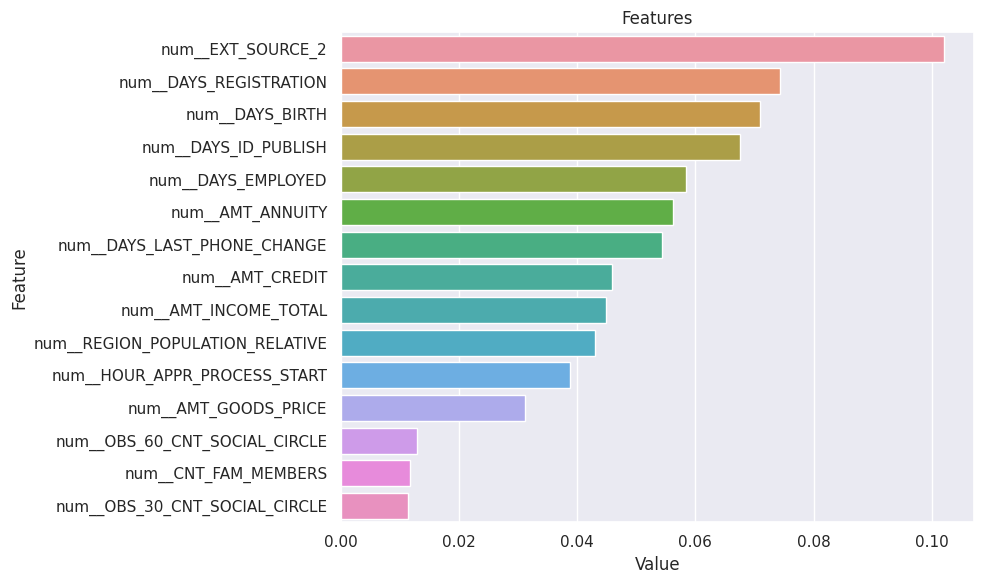

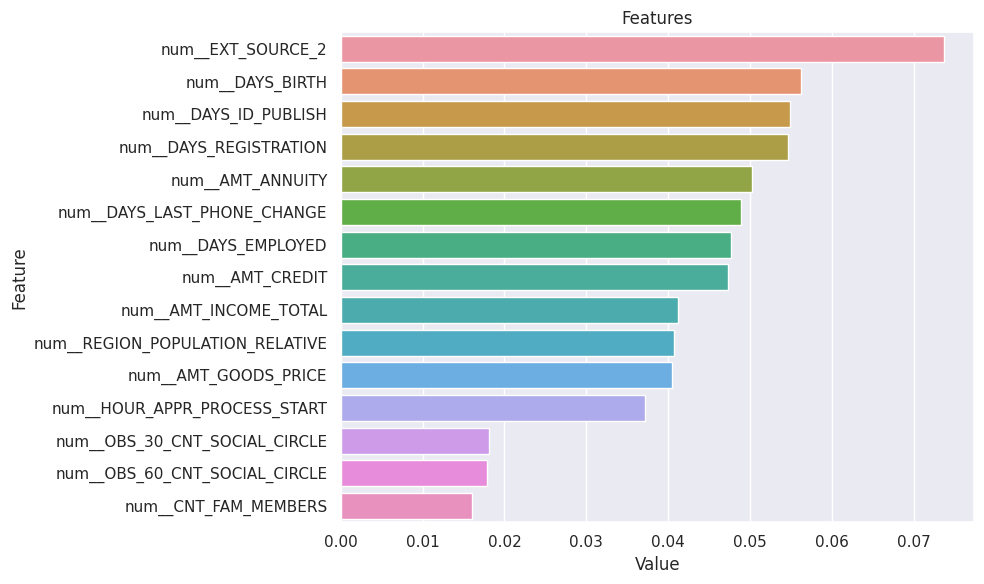

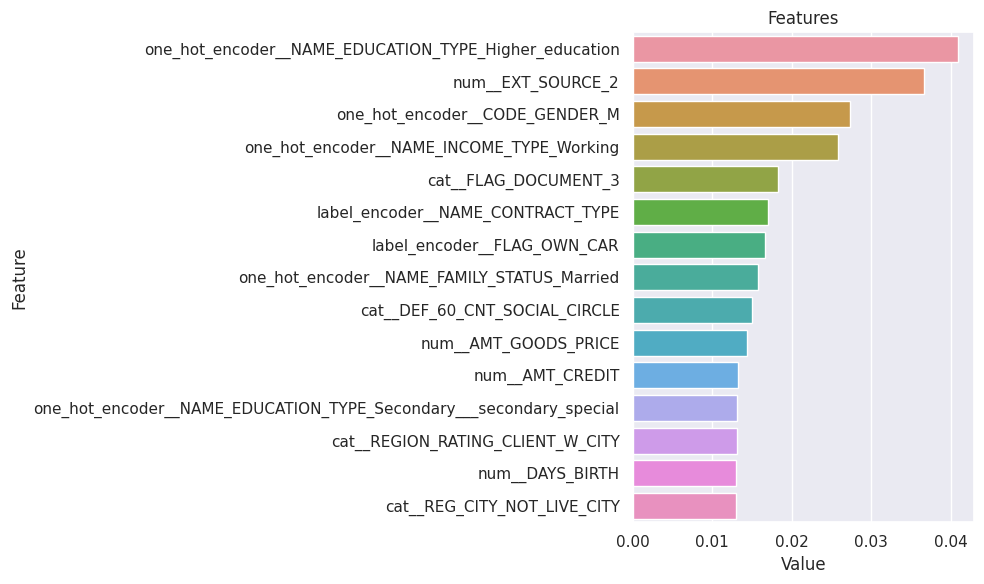

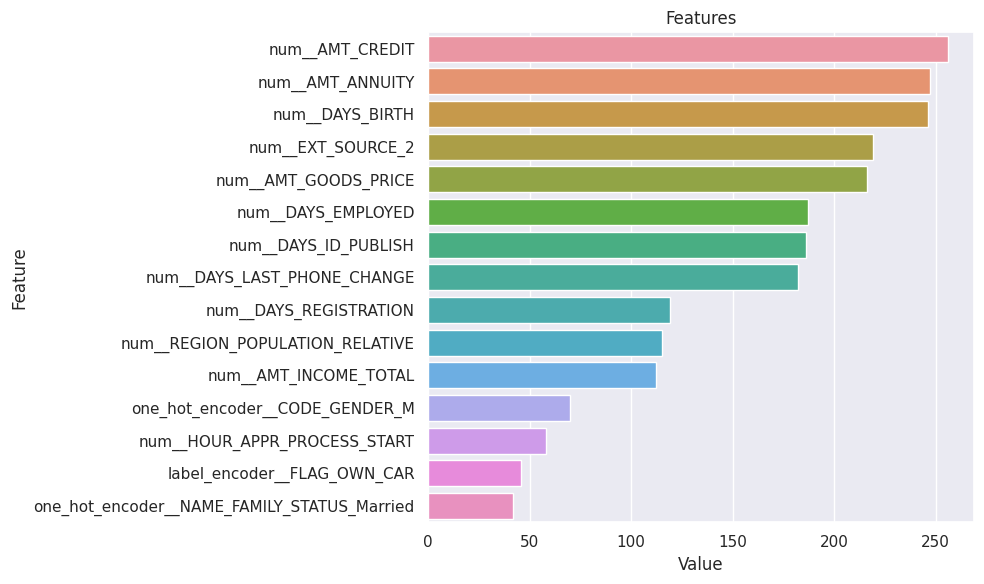

In [26]:
importance_dict = {}
for name, model in models.items():
    features_cols = plot_importance(model.feature_importances_, X_train, 15)
    importance_dict[name] = features_cols

In [27]:
for name, model in models.items():
    print(name)
    models[name] = model.fit(X_train[importance_dict[name]], y_train)


DT
RF
XGBoost
LightGBM


In [28]:
dt_model = models['DT']
rf_model = models['RF']
xgboost_model = models['XGBoost']
light_model = models['LightGBM']

In [29]:
voting_clf = VotingClassifier(estimators=[
    ('DT', dt_model),
    ('RF', rf_model),
    ('XGBoost', xgboost_model),
    ('LightGBM', light_model)
], voting='soft')

In [30]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('DT', DecisionTreeClassifier()),
                             ('RF', RandomForestClassifier()),
                             ('XGBoost',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='logloss',
                                            feature_types=None, gamma=None,
                                            grow_...
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('LightGBM', LGBMClassifier(verbose=-1))],
                 voting='soft')

In [31]:
print("Model Accuracy:", voting_clf.score(X_test, y_test))

Model Accuracy: 0.9186137033277821


## Test on test data

In [32]:
path = '/kaggle/input/application-datasets/application_test.csv'
df_test = pd.read_csv(path)
df_test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.000,568800.000,20560.500,450000.000,Unaccompanied,Working,Higher education,Married,House / apartment,0.019,-19241,-2329,-5170.000,-812,NaN,1,1,0,1,0,1,NaN,2.000,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,0.753,0.790,0.160,0.066,0.059,0.973,NaN,NaN,NaN,0.138,0.125,NaN,NaN,NaN,0.051,NaN,NaN,0.067,0.061,0.973,NaN,NaN,NaN,0.138,0.125,NaN,NaN,NaN,0.053,NaN,NaN,0.067,0.059,0.973,NaN,NaN,NaN,0.138,0.125,NaN,NaN,NaN,0.051,NaN,NaN,NaN,block of flats,0.039,"Stone, brick",No,0.000,0.000,0.000,0.000,-1740.000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000,0.000,0.000,0.000,0.000,0.000
1,100005,Cash loans,M,N,Y,0,99000.000,222768.000,17370.000,180000.000,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.036,-18064,-4469,-9118.000,-1623,NaN,1,1,0,1,0,0,Low-skill Laborers,2.000,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,0.565,0.292,0.433,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,0.000,0.000,0.000,0.000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000,0.000,0.000,0.000,0.000,3.000
2,100013,Cash loans,M,Y,Y,0,202500.000,663264.000,69777.000,630000.000,NaN,Working,Higher education,Married,House / apartment,0.019,-20038,-4458,-2175.000,-3503,5.000,1,1,0,1,0,0,Drivers,2.000,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,NaN,0.700,0.611,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,0.000,0.000,0.000,-856.000,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000,0.000,0.000,0.000,1.000,4.000
3,100028,Cash loans,F,N,Y,2,315000.000,1575000.000,49018.500,1575000.

In [33]:
transformed_data = preprocessor.transform(df_test)
print("Test Predicitons:", voting_clf.predict(transformed_data))

/tmp/ipykernel_30/3272650484.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


/tmp/ipykernel_30/2391436545.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-1.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
/tmp/ipykernel_30/2391436545.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-30348.5' has dtype incompati

Test Predicitons: [0 0 0 ... 0 0 0]


## Cross Validation

In [35]:
from sklearn.model_selection import cross_validate, GridSearchCV

In [36]:
cv_results = cross_validate(voting_clf, X_df, y, cv=3, scoring=["accuracy", "f1", "roc_auc"])
print(f"Accuracy: {cv_results['test_accuracy'].mean()}")
print(f"F1Score: {cv_results['test_f1'].mean()}")
print(f"ROC_AUC: {cv_results['test_roc_auc'].mean()}")

Accuracy: 0.918672828892757
F1Score: 0.031673772510226406
ROC_AUC: 0.6965782664978879


# Parameters Optimizations

In [37]:

cart_params = {'max_depth': range(1, 20),
               "min_samples_split": range(2, 30)}

rf_params = {"max_depth": [8, 15, None],
             "max_features": [5, 7, "auto"],
             "min_samples_split": [15, 20],
             "n_estimators": [200, 300]}

xgboost_params = {"learning_rate": [0.1, 0.01],
                  "max_depth": [5, 8],
                  "n_estimators": [100, 200]}

lightgbm_params = {"learning_rate": [0.01, 0.1],
                   "n_estimators": [300, 500]}

In [38]:
classifiers = [("DT", models['DT'], cart_params),
               ("RF", models['RF'], rf_params),
               ('XGBoost', models['XGBoost'], xgboost_params),
               ('LightGBM', models['LightGBM'], lightgbm_params)]


In [39]:
def hyperparameter_optimization(X, y, cv=3, scoring="roc_auc"):
    print("Hyperparameter Optimization....")
    best_models = {}
    for name, classifier, params in classifiers:
        print(f"########## {name} ##########")
        cv_results = cross_validate(classifier, X[importance_dict[name]], y, cv=cv, scoring=scoring)
        print(f"{scoring} (Before): {round(cv_results['test_score'].mean(), 4)}")

        gs_best = GridSearchCV(classifier, params, cv=cv, n_jobs=-1, verbose=False).fit(X[importance_dict[name]], y)
        final_model = classifier.set_params(**gs_best.best_params_)

        cv_results = cross_validate(final_model, X[importance_dict[name]], y, cv=cv, scoring=scoring)
        print(f"{scoring} (After): {round(cv_results['test_score'].mean(), 4)}")
        print(f"{name} best params: {gs_best.best_params_}", end="\n\n")
        best_models[name] = final_model
    return best_models

In [40]:
best_models = hyperparameter_optimization(X_df, y)

Hyperparameter Optimization....
########## DT ##########
roc_auc (Before): 0.5258
roc_auc (After): 0.6003
DT best params: {'max_depth': 1, 'min_samples_split': 2}

########## RF ##########
roc_auc (Before): 0.6695


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

roc_auc (After): 0.6857
RF best params: {'max_depth': None, 'max_features': 'auto', 'min_samples_split': 20, 'n_estimators': 300}

########## XGBoost ##########
roc_auc (Before): 0.6946
roc_auc (After): 0.7042
XGBoost best params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}

########## LightGBM ##########
roc_auc (Before): 0.7019
roc_auc (After): 0.7027
LightGBM best params: {'learning_rate': 0.01, 'n_estimators': 500}



In [41]:
def voting_classifier(best_models, X, y):
    print("Voting Classifier...")

    voting_clf = VotingClassifier(estimators=[('DT', best_models["DT"]),
                                              ('RF', best_models["RF"]),
                                              ('XGBoost', best_models["XGBoost"]),
                                              ('LightGBM', best_models["LightGBM"])],
                                  voting='soft').fit(X, y)

    cv_results = cross_validate(voting_clf, X, y, cv=3, scoring=["accuracy", "f1", "roc_auc"])
    print(f"Accuracy: {cv_results['test_accuracy'].mean()}")
    print(f"F1Score: {cv_results['test_f1'].mean()}")
    print(f"ROC_AUC: {cv_results['test_roc_auc'].mean()}")
    return voting_clf

In [42]:
voting_clf = voting_classifier(best_models, X_df.values, y.values)


Voting Classifier...


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

Accuracy: 0.9192711805414276
F1Score: 0.0
ROC_AUC: 0.7147513286244931


In [43]:
X_test.shape

(101479, 177)

In [44]:
def train_prediction_model(model, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=2024)
    #model = RandomForestClassifier()
    model.fit(X_train, y_train)
    y_score = model.predict_proba(X_test)[:, 1]
    return model, y_score, X_test

In [45]:
for name, model in models.items():
    X = X_train
    
    print(f"The Model is {name}")
    X = X[importance_dict[name]]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=2024)
        
    for index in range(len(X_test.columns)-1, 1, -1):  
        y_score_before = model.predict_proba(X_test)[:, 1]
        roc_score_before = roc_auc_score(y_test, y_score_before)
        print("Roc score Before:", roc_score_before)
        
        last_col = X.columns[index]
        X = X.drop(last_col, axis=1)
        print("X shape: ", X.shape)
        
        model_rf, y_score_after, X_test = train_prediction_model(model, X, y)
        roc_score_after = roc_auc_score(y_test, y_score_after)
        print("Roc score after:", roc_score_after)
        
        if roc_score_before - roc_score_after < 0.001:
            print(f"the feature is {last_col}")
            importance_dict[name].pop(index)
        print("-------------------------------------------")
print(importance_dict['RF'])

The Model is DT


ValueError: Found input variables with inconsistent numbers of samples: [206032, 307511]

In [ ]:
pipelines = []

for name, model in classifiers:
    print(X_train[importance_dict[name]])
    model_pipeline = Pipeline([(f'model_{name}', model)])
    model_pipeline.fit(X_train[importance_dict[name]], y_train)
    pipelines.append(model_pipeline)
    

In [ ]:
pipe = Pipeline([
    ('model_pipelines', model_pipelines),
    ('ensemble', ensemble)
])

In [ ]:
ensemble = VotingClassifier(estimators=[
    (name, model) for name, model in classifiers
], voting='soft')


In [ ]:
pipe.fit(X_train, y_train)